In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/colab/ImageStyleTransfer")

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
# desired size of the output image
imsize = 512 #if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# style_img1 = image_loader("style/mosaic.jpg")
# style_img2 = image_loader("style/style_5.jpg")

style_img1 = image_loader("style/feathers.jpg")
# style_img2 = image_loader("style/candy.jpg")
style_img2 = image_loader("style/mosaic.jpg")
 
content_img = image_loader("content/test.jpg")

print(style_img1.size())
print(content_img.size())


assert style_img1.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


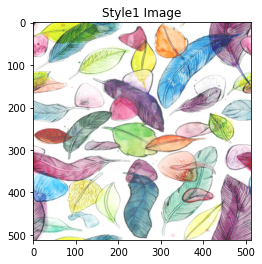

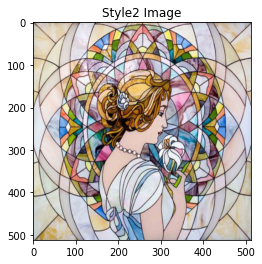

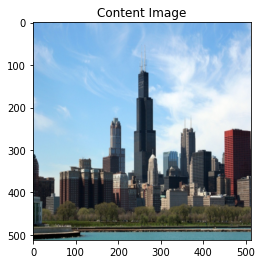

In [61]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img1, title='Style1 Image')
plt.figure()
imshow(style_img2, title='Style2 Image')
plt.figure()
imshow(content_img, title='Content Image')


In [62]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature1,target_feature2):
        super(StyleLoss, self).__init__()
        self.target1 = gram_matrix(target_feature1).detach()
        self.target2 = gram_matrix(target_feature2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss1 = F.mse_loss(G, self.target1)
        self.loss2 = F.mse_loss(G, self.target2)
        return input

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [13]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img1, style_img2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    
    # mynet = Net().to(device)

    
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    # model.add_module('my_module', mynet)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature1 = model(style_img1).detach()
            target_feature2 = model(style_img2).detach()

            style_loss = StyleLoss(target_feature1, target_feature2)

            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

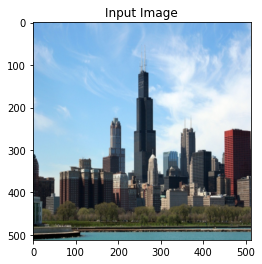

In [14]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [47]:
def get_input_optimizer(input_img, lr=0.1):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()], lr=lr)
    return optimizer

In [48]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img1, style_img2, input_img, lr=0.1, num_steps=300, style1_weight=10000, style2_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img1, style_img2, content_img)
    
    optimizer = get_input_optimizer(input_img, lr)
    
    # optimizer = get_input_optimizer(input_img)
    # mynet = Net().to(device)

    # optimizer = optim.Adam(mynet.parameters())

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            # model(input_img)
            model(input_img)
            style_score1 = 0
            style_score2 = 0
            content_score = 0
            
            
            for sl in style_losses:
                style_score1 += sl.loss1
            
            for sl in style_losses:
                style_score2 += sl.loss2

            for cl in content_losses:
                content_score += cl.loss

            
            style_score1 *= style1_weight
            style_score2 *= style2_weight
            content_score *= content_weight
            loss = style_score1 + content_score + style_score2
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style1 Loss : {:4f} Style2 Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score1.item(), style_score2.item(), content_score.item()))
                print()

            return style_score1 + content_score + style_score2

        optimizer.step(closure)
    # for name, parameter in model.named_parameters():
    #   print(name, parameter)   
    # print(model[1]) 
    # input_img = mynet(input_img)
    

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style1 Loss : 21.497028 Style2 Loss : 0.000000 Content Loss: 11.850623

run [100]:
Style1 Loss : 8.902715 Style2 Loss : 0.000000 Content Loss: 12.510798

run [150]:
Style1 Loss : 5.039153 Style2 Loss : 0.000000 Content Loss: 12.046314

run [200]:
Style1 Loss : 3.990101 Style2 Loss : 0.000000 Content Loss: 11.540886

run [250]:
Style1 Loss : 3.681090 Style2 Loss : 0.000000 Content Loss: 11.179076

run [300]:
Style1 Loss : 3.454766 Style2 Loss : 0.000000 Content Loss: 10.968637

run [350]:
Style1 Loss : 3.244704 Style2 Loss : 0.000000 Content Loss: 10.827056

run [400]:
Style1 Loss : 3.040538 Style2 Loss : 0.000000 Content Loss: 10.736609

run [450]:
Style1 Loss : 2.842832 Style2 Loss : 0.000000 Content Loss: 10.678217

run [500]:
Style1 Loss : 2.678026 Style2 Loss : 0.000000 Content Loss: 10.641243

run [550]:
Style1 Loss : 2.557224 Style2 Loss : 0.000000 Content Loss: 10.635574

run [600]:
Style1 Loss : 2.462420 Style2 Loss : 0.000000 Content Loss: 10.713764

run [650]:
Style

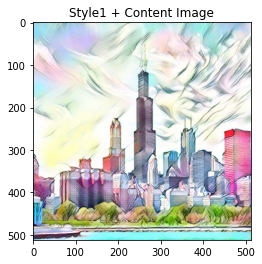

In [76]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800, style2_weight=1e-5)

plt.figure()
imshow(output, title='Style1 + Content Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style1 Loss : 0.000000 Style2 Loss : 70.456474 Content Loss: 21.088991

run [100]:
Style1 Loss : 0.000000 Style2 Loss : 17.608091 Content Loss: 24.506998

run [150]:
Style1 Loss : 0.000000 Style2 Loss : 5.331286 Content Loss: 22.739912

run [200]:
Style1 Loss : 0.000000 Style2 Loss : 3.160285 Content Loss: 21.286335

run [250]:
Style1 Loss : 0.000000 Style2 Loss : 2.652274 Content Loss: 20.491543

run [300]:
Style1 Loss : 0.000000 Style2 Loss : 2.452836 Content Loss: 20.017952

run [350]:
Style1 Loss : 0.000000 Style2 Loss : 2.349789 Content Loss: 19.693066

run [400]:
Style1 Loss : 0.000000 Style2 Loss : 2.292077 Content Loss: 19.448658

run [450]:
Style1 Loss : 0.000000 Style2 Loss : 2.245006 Content Loss: 19.271423

run [500]:
Style1 Loss : 0.000000 Style2 Loss : 2.214478 Content Loss: 19.143353

run [550]:
Style1 Loss : 0.000000 Style2 Loss : 2.198597 Content Loss: 19.056078

run [600]:
Style1 Loss : 0.000000 Style2 Loss : 2.299053 Content Loss: 18.996365

run [650]:
Styl

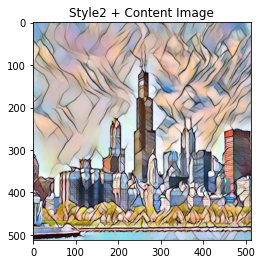

In [77]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800, style1_weight=1e-5)

plt.figure()
imshow(output, title='Style2 + Content Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style1 Loss : 54.837353 Style2 Loss : 104.152939 Content Loss: 17.149355

run [100]:
Style1 Loss : 49.200375 Style2 Loss : 58.925255 Content Loss: 20.032261

run [150]:
Style1 Loss : 46.148430 Style2 Loss : 50.807652 Content Loss: 18.848831

run [200]:
Style1 Loss : 45.514275 Style2 Loss : 49.604141 Content Loss: 17.598881

run [250]:
Style1 Loss : 45.354702 Style2 Loss : 49.220100 Content Loss: 16.917402

run [300]:
Style1 Loss : 45.260372 Style2 Loss : 49.022892 Content Loss: 16.506947

run [350]:
Style1 Loss : 45.170719 Style2 Loss : 48.898048 Content Loss: 16.213903

run [400]:
Style1 Loss : 45.071262 Style2 Loss : 48.820408 Content Loss: 15.988076

run [450]:
Style1 Loss : 44.958969 Style2 Loss : 48.790215 Content Loss: 15.812160

run [500]:
Style1 Loss : 44.828651 Style2 Loss : 48.808380 Content Loss: 15.669000

run [550]:
Style1 Loss : 44.740723 Style2 Loss : 48.804676 Content Loss: 15.554199

run [600]:
Style1 Loss : 44.668781 Style2 Loss : 48.791653 Content Loss: 15.

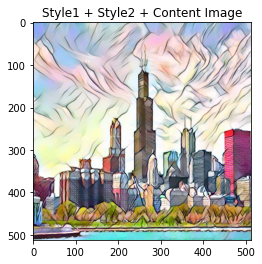

In [79]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img1, style_img2, input_img, num_steps=800)

plt.figure()
imshow(output, title='Style1 + Style2 + Content Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F3951AEE9E8>


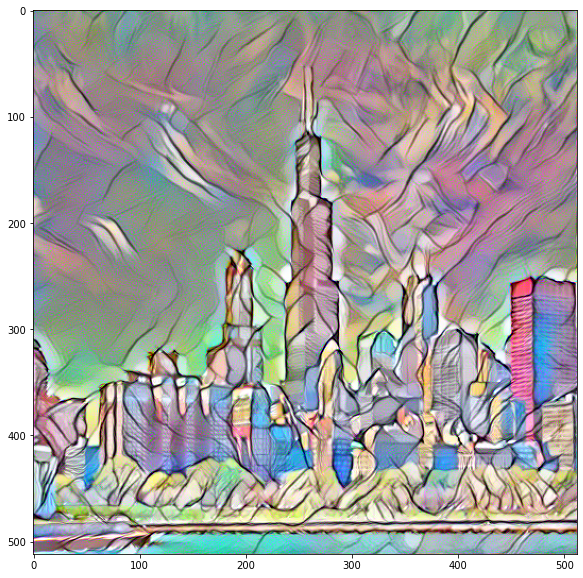

In [66]:
plt.figure(figsize=(10,10))
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

image = output.cpu().clone()  # we clone the tensor to not do changes on it
image = image.squeeze(0)      # remove the fake batch dimension
image = unloader(image)
plt.imshow(image)
print(image)
# sphinx_gallery_thumbnail_number = 4

plt.show()

